In [1]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, KFold, cross_validate
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.utils import shuffle

# Helper file
import helper_data_generator

# Models
from PEA import PerformanceEnrichmentAnalysisClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# Metric
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, precision_score, \
recall_score, SCORERS, roc_auc_score, roc_curve, auc, precision_recall_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
%matplotlib inline

In [55]:
clf_list = [
     #PerformanceEnrichmentAnalysisClassifier(
     #   number_of_clusters=20, permutations=100),
     #KNeighborsClassifier(3),
     DummyClassifier(strategy='uniform'),
     DummyClassifier(strategy='most_frequent'),
     #DummyClassifier(strategy='stratified'),
     # SVC(kernel="linear", C=0.025),
     # SVC(gamma=2, C=1),
     # DecisionTreeClassifier(max_depth=5),
     # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
     # MLPClassifier(alpha=0.01),
     # AdaBoostClassifier(),
     #GaussianNB(),
     # QuadraticDiscriminantAnalysis()
]

In [183]:
def get_synthetic_data(noise):
    '''
    Input: noise
    Return: Features,X and lateness,y
    '''
    X, y = helper_data_generator.make_classification(n_samples=5000,
                                       n_features=26,
                                       n_informative=21,
                                       n_redundant=5,
                                       n_repeated=0,
                                       n_classes=3,
                                       n_clusters_per_class=1,
                                       class_sep=0.9,
                                       flip_y=noise,
                                       weights=[0.65, 0.01, 0.34])
    return X, y

In [185]:
def noise_classwise_updated(clf, metric, class_label, folds, list_values):
    '''
    Input: {clf = classfier,
            metric= scoring metric, 
            class_label= {0:-1, 1:0: 2:1},
            folds = corss validation folds, 
            list_values = noise range to be specified}
    Dependencies: { StratifiedShuffleSplit(), 
                    get_synthetic_data(), 
                    label_binarize(),
                    roc_curve(),
                    precision_recall_curve(),
                    multilabel_confusion_matrix() }
    Return: list_of_classwise_scoring for class labels, list_of_roc_auc for class labels
    '''
    list_of_classwise_scoring = []
    list_of_roc_auc = []
    
    for noise in list_values:
        list_temp_A = []
        list_temp_B = []
        list_temp_C = []
        
        list_temp_roc_A = []
        list_temp_roc_B = []
        list_temp_roc_C = []
        
        X, y = get_synthetic_data(noise)
        
        skf = StratifiedShuffleSplit(n_splits=folds, test_size=0.2)
        for train_index, test_index in skf.split(X, y): # returns index of shuffled and splitted values
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            n_classes = len(np.unique(y_test))
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            
            #Calculate roc_auc
            y_test = label_binarize(y_test, classes=[0,1,2])
            prediction = label_binarize(prediction, classes=[0,1,2])
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
                # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                #print('roc_auc_class: ',roc_auc)

            list_temp_roc_A.append(roc_auc[0])
            list_temp_roc_B.append(roc_auc[1])
            list_temp_roc_C.append(roc_auc[2])
            
            if metric=='roc_auc_metric':
                y_test = label_binarize(y_test, classes=[0,1,2])
                prediction = label_binarize(prediction, classes=[0,1,2])
                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                #print('roc_auc_class: ',roc_auc)

                list_temp_A.append(roc_auc[0])
                list_temp_B.append(roc_auc[1])
                list_temp_C.append(roc_auc[2])
            elif metric=='precision_recall':
                y_test = label_binarize(y_test, classes=[0,1,2])
                prediction = label_binarize(prediction, classes=[0,1,2])
                precision = dict()
                recall = dict()
                pr_auc = dict()
               
                for i in range(n_classes):
                    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], prediction[:, i])
                    pr_auc[i] = auc(recall[i], precision[i])

                list_temp_A.append(pr_auc[0])
                list_temp_B.append(pr_auc[1])
                list_temp_C.append(pr_auc[2])
            else:
                mcm = multilabel_confusion_matrix(y_test, prediction, labels=[0,1,2])
                tn = mcm[:, 0, 0]
                tp = mcm[:, 1, 1]
                fn = mcm[:, 1, 0]
                fp = mcm[:, 0, 1]
                if metric=='fnr':
                    fnr_class_A = (fn / (fn + tp))[0]
                    fnr_class_B = (fn / (fn + tp))[1]
                    fnr_class_C = (fn / (fn + tp))[2]
                    list_temp_A.append(fnr_class_A)
                    list_temp_B.append(fnr_class_B)
                    list_temp_C.append(fnr_class_C)
                elif metric=='fpr':
                    fpr_class_A = (fp / (tn + fp))[0]
                    fpr_class_B = (fp / (tn + fp))[1]
                    fpr_class_C = (fp / (tn + fp))[2]
                    list_temp_A.append(fpr_class_A)
                    list_temp_B.append(fpr_class_B)
                    list_temp_C.append(fpr_class_C)
                elif metric=='sensitivity':
                    sensitivity_recall_tpr_class_A = (tp / (tp + fn))[0]
                    sensitivity_recall_tpr_class_B = (tp / (tp + fn))[1]
                    sensitivity_recall_tpr_class_C = (tp / (tp + fn))[2]
                    list_temp_A.append(sensitivity_recall_tpr_class_A)
                    list_temp_B.append(sensitivity_recall_tpr_class_B)
                    list_temp_C.append(sensitivity_recall_tpr_class_C)
                elif metric=='specificity':
                    speificity_neg_recall_tnr_class_A = (tn / (tn + fp))[0]
                    speificity_neg_recall_tnr_class_B = (tn / (tn + fp))[1]
                    speificity_neg_recall_tnr_class_C = (tn / (tn + fp))[2]
                    list_temp_A.append(speificity_neg_recall_tnr_class_A)
                    list_temp_B.append(speificity_neg_recall_tnr_class_B)
                    list_temp_C.append(speificity_neg_recall_tnr_class_C)
                
        list_of_classwise_scoring.append((np.mean(list_temp_A),np.mean(list_temp_B),np.mean(list_temp_C)))
           
        list_of_roc_auc.append((np.mean(list_temp_roc_A),np.mean(list_temp_roc_B),np.mean(list_temp_roc_C)))
            
        
    #display(np.mean(np.round(list_of_roc_auc,3)[:,0]))
    #display(np.mean(np.round(list_of_roc_auc,3)[:,1]))
    #display(np.mean(np.round(list_of_roc_auc,3)[:,2]))
    #display('roc: ',list(np.round(list_of_roc_auc,3)[:,0]))
    
    if class_label=='0':
        return list(np.round(list_of_classwise_scoring,3)[:,0]),np.mean(np.round(list_of_roc_auc,3)[:,0])
    elif class_label=='1':
        return list(np.round(list_of_classwise_scoring,3)[:,1]),np.mean(np.round(list_of_roc_auc,3)[:,1]) 
    elif class_label=='2':
        return list(np.round(list_of_classwise_scoring,3)[:,2]),np.mean(np.round(list_of_roc_auc,3)[:,2]) 

In [186]:
def noise_classwise(clf, metric, class_label, folds):
    '''
    Input: {clf = classfier,
            metric= scoring metric, 
            class_label= {0:-1, 1:0: 2:1},
            folds = corss validation folds, 
    Dependencies: { StratifiedShuffleSplit(), 
                    get_synthetic_data(), 
                    label_binarize(),
                    roc_curve(),
                    precision_recall_curve(),
                    multilabel_confusion_matrix() }
    Return: list_of_classwise_scoring for class labels
    '''
    list_of_classwise_scoring = []
    list_values = list(np.round(np.arange(0.2, 0.6, 0.01),2))
    
    for noise in list_values:
        list_temp_A = []
        list_temp_B = []
        list_temp_C = []
        
        X, y = get_synthetic_data(noise)
        
        skf = StratifiedShuffleSplit(n_splits=folds, test_size=0.2)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            n_classes = len(np.unique(y_test))
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            
            if metric=='roc_auc_metric':
                y_test = label_binarize(y_test, classes=[0,1,2])
                prediction = label_binarize(prediction, classes=[0,1,2])
                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                #print('roc_auc_class: ',roc_auc)

                list_temp_A.append(roc_auc[0])
                list_temp_B.append(roc_auc[1])
                list_temp_C.append(roc_auc[2])
            elif metric=='precision_recall':
                y_test = label_binarize(y_test, classes=[0,1,2])
                prediction = label_binarize(prediction, classes=[0,1,2])
                precision = dict()
                recall = dict()
                pr_auc = dict()
               
                for i in range(n_classes):
                    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], prediction[:, i])
                    pr_auc[i] = auc(recall[i], precision[i])

                list_temp_A.append(pr_auc[0])
                list_temp_B.append(pr_auc[1])
                list_temp_C.append(pr_auc[2])
            else:
                mcm = multilabel_confusion_matrix(y_test, prediction, labels=[0,1,2])
                tn = mcm[:, 0, 0]
                tp = mcm[:, 1, 1]
                fn = mcm[:, 1, 0]
                fp = mcm[:, 0, 1]
                if metric=='fnr':
                    fnr_class_A = (fn / (fn + tp))[0]
                    fnr_class_B = (fn / (fn + tp))[1]
                    fnr_class_C = (fn / (fn + tp))[2]
                    list_temp_A.append(fnr_class_A)
                    list_temp_B.append(fnr_class_B)
                    list_temp_C.append(fnr_class_C)
                elif metric=='fpr':
                    fpr_class_A = (fp / (tn + fp))[0]
                    fpr_class_B = (fp / (tn + fp))[1]
                    fpr_class_C = (fp / (tn + fp))[2]
                    list_temp_A.append(fpr_class_A)
                    list_temp_B.append(fpr_class_B)
                    list_temp_C.append(fpr_class_C)
                elif metric=='sensitivity':
                    sensitivity_recall_tpr_class_A = (tp / (tp + fn))[0]
                    sensitivity_recall_tpr_class_B = (tp / (tp + fn))[1]
                    sensitivity_recall_tpr_class_C = (tp / (tp + fn))[2]
                    list_temp_A.append(sensitivity_recall_tpr_class_A)
                    list_temp_B.append(sensitivity_recall_tpr_class_B)
                    list_temp_C.append(sensitivity_recall_tpr_class_C)
                elif metric=='specificity':
                    speificity_neg_recall_tnr_class_A = (tn / (tn + fp))[0]
                    speificity_neg_recall_tnr_class_B = (tn / (tn + fp))[1]
                    speificity_neg_recall_tnr_class_C = (tn / (tn + fp))[2]
                    list_temp_A.append(speificity_neg_recall_tnr_class_A)
                    list_temp_B.append(speificity_neg_recall_tnr_class_B)
                    list_temp_C.append(speificity_neg_recall_tnr_class_C)
                
        list_of_classwise_scoring.append((np.mean(list_temp_A),np.mean(list_temp_B),np.mean(list_temp_C)))
    
    if class_label=='0':
        return list(np.round(list_of_classwise_scoring,3)[:,0]) # class A or -1
    elif class_label=='1':
        return list(np.round(list_of_classwise_scoring,3)[:,1]) # class A or -1
    elif class_label=='2':
        return list(np.round(list_of_classwise_scoring,3)[:,2]) # class A or -1

In [199]:
def create_dict_clf_noise_classwise_updated(classifier_list, metric, class_label, folds, list_values):
    '''
    Input: {classifier_list = list of classfiers,
            metric= scoring metric, 
            class_label= {0:-1, 1:0: 2:1},
            folds = corss validation folds, 
            list_values = noise range to be specified}
    Dependencies: { noise_classwise_updated() }
    Return: new_df, dict_roc_auc
    '''
    list_lists_clf = []
    list_lists_clf_metric = []
    dict_roc_auc = {}

    for i in range(len(classifier_list)):
        list_lists_clf.append('list'+str(i))

    for i in range(len(list_lists_clf)):
        list_lists_clf[i] = []
    
    for i in range(len(classifier_list)):
        if isinstance(classifier_list[i],PerformanceEnrichmentAnalysisClassifier):
            name = 'PEA'
            temp = noise_classwise_updated(classifier_list[i], metric, class_label, folds, list_values)
            dict_roc_auc[name] = np.round(temp[1],3)
            list_lists_clf_metric.append((name,temp[0]))
            #list_lists_clf_metric.append((name,noise_classwise_updated(classifier_list[i], metric, class_label, folds)))
        elif isinstance(classifier_list[i],DummyClassifier):
            if classifier_list[i].strategy=='uniform':
                #display(classifier_list[i])
                temp = noise_classwise_updated(classifier_list[i], metric, class_label, folds, list_values)
                dict_roc_auc[str(classifier_list[i]).split('(')[0]+'_uniform'] = np.round(temp[1],3)
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_uniform',temp[0]))
                #list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_uniform',noise_classwise_updated(classifier_list[i], metric, class_label, folds)))
            elif classifier_list[i].strategy=='most_frequent':
                #display(classifier_list[i])
                temp = noise_classwise_updated(classifier_list[i], metric, class_label, folds, list_values)
                dict_roc_auc[str(classifier_list[i]).split('(')[0]+'_most_frequent'] = np.round(temp[1],3)
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_most_frequent',temp[0]))
            elif classifier_list[i].strategy=='stratified':
                #display(classifier_list[i])
                temp = noise_classwise_updated(classifier_list[i], metric, class_label, folds, list_values)
                dict_roc_auc[str(classifier_list[i]).split('(')[0]+'_stratified'] = np.round(temp[1],3)
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_stratified',temp[0]))

                #list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_most_frequent',noise_classwise_updated(classifier_list[i], metric, class_label, folds)))
        else:
            temp = noise_classwise_updated(classifier_list[i], metric, class_label, folds, list_values)
            dict_roc_auc[str(classifier_list[i]).split('(')[0]] = np.round(temp[1],3)
            list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0],temp[0]))
            #list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0],noise(classifier_list[i], metric, folds)))
    
    dict_items_scores= {}
    
    for i in range(np.array(list_lists_clf_metric).shape[0]):
        dict_items_scores[np.unique(np.array(list_lists_clf_metric).T[0][i])[0]] = np.hstack((np.array(list_lists_clf_metric).T[1][i]))
    
    #display(dict_roc_auc)
    new_df, dict_roc_auc  = create_dataframe_classwise(dict_items_scores, class_label, metric, dict_roc_auc, list_values)
    
    return new_df, dict_roc_auc
    

In [189]:
def create_dict_clf_noise_classwise(classifier_list, metric, class_label, folds):
    '''
    Input: {classifier_list = list of classfiers,
            metric= scoring metric, 
            class_label= {0:-1, 1:0: 2:1},
            folds = corss validation folds } 
    Dependencies: { noise_classwise_updated() }
    '''
    list_lists_clf = []
    list_lists_clf_metric = []

    for i in range(len(classifier_list)):
        list_lists_clf.append('list'+str(i))

    for i in range(len(list_lists_clf)):
        list_lists_clf[i] = []
    
    print(metric)
    for i in range(len(classifier_list)):
        if isinstance(classifier_list[i],PerformanceEnrichmentAnalysisClassifier):
            name = 'PEA'
            list_lists_clf_metric.append((name,noise_classwise(classifier_list[i], metric, class_label, folds)))
        elif isinstance(classifier_list[i],DummyClassifier):
            if classifier_list[i].strategy=='uniform':
                display(classifier_list[i])
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_uniform',noise_classwise(classifier_list[i], metric, class_label, folds)))
            elif classifier_list[i].strategy=='most_frequent':
                display(classifier_list[i])
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_most_frequent',noise_classwise(classifier_list[i], metric, class_label, folds)))
            elif classifier_list[i].strategy=='stratified':
                display(classifier_list[i])
                list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0]+'_stratified',noise_classwise(classifier_list[i], metric, class_label, folds)))
        else:
            list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0],noise_classwise(classifier_list[i], metric, class_label, folds)))
            #list_lists_clf_metric.append((str(classifier_list[i]).split('(')[0],noise(classifier_list[i], metric, folds)))
    
    #display(np.hstack((np.array(list_lists_clf_metric).T[1])))
    
    dict_items= {}

    for i in range(np.array(list_lists_clf_metric).shape[0]):
        dict_items[np.unique(np.array(list_lists_clf_metric).T[0][i])[0]] = np.hstack((np.array(list_lists_clf_metric).T[1][i]))

    create_dataframe_classwise(dict_items, class_label, metric)

In [208]:

def create_dataframe_classwise(dict_items, class_label, metric, dict_roc_auc, list_values):
    '''
    Input: {dict_items_scores = dictionary which is converted to a dataframe
            class_label= {0:-1, 1:0: 2:1},
            metric= scoring metric, 
            dict_roc_auc = dictionary with mean roc auc values classwise for the list of noise,
            list_values = noise range to be specified }
    Dependencies: { plot_box_df(),
                    plot_line_df() }
    Returns: new_df
    '''
    list_lists_clf = []
    
    for i in range(len(list_values)):
        list_lists_clf.append('list'+str(i))

    for i in range(len(list_values)):
        list_lists_clf[i] = []

    for i in range(len(list_values)):
        for key, value in dict_items.items():
            #print(key, value)
            list_lists_clf[i].append((key,value[i]))
        #print(len(value))
        #print(np.array(dict_items['SVC'].T).reshape(-1,1))

    #print(list_lists_clf)

    list_lists_clf = np.array(list_lists_clf)
    a = list_lists_clf.T[0].reshape(1,-1)
    a = a[0]

    _, idx = np.unique(a, return_index=True)
    x = a[np.sort(idx)]

    #list_noise_vals = list(np.round(np.arange(0.2, 0.6, 0.01),2))
    list_noise_vals = np.array(list_values)

    y = list_lists_clf.T[1]

    col_noise = []
    for i in list_noise_vals:
        col_noise.append(('noise_'+str(i)))
        
    df_1 = pd.DataFrame(y.T, index=col_noise, columns=x, dtype='float')
    
    #display(df_1)
    
    plot_box_df(list_noise_vals, metric, df_1, 'noise', (16,6), class_label, dict_roc_auc)
    plot_line_df(list_noise_vals, metric, df_1, 'noise', (16,8), class_label, dict_roc_auc)
    
    return df_1, dict_roc_auc
    

In [209]:

def plot_box_df(range_param, param, df_1, metric, size, class_label, dict_roc_auc):
    
    df_2 = df_1.copy()
    df_2.reset_index(inplace=True)
    df_2['noise'] = df_2['index'].str.lstrip('noise_').astype('float64')
    df_2.drop(columns=['index'], inplace=True)
    df_2.set_index('noise',inplace=True)
    
    fig, ax = plt.subplots(figsize=size)
    
    df_2.reset_index(inplace=True)
    
    sns.boxplot(data=df_2.iloc[:,1:], orient='h', palette='cool')
    sns.swarmplot(data=df_2.iloc[:,1:],orient='h', palette='plasma')
    
    ax_legend_list = []
    clf_list = df_2.columns[1:]
    
#     for i in range(len(df_2.columns[1:])):
#         ax_legend_list.append(str(clf_list[i])+':{ Mean = '+ str(round(df_2.mean(),3)[i+1]) +', SD = '+str(round(df_2.std(),3)[i+1])+', ROC_AUC = '+str(dict_roc_auc[clf_list[i]])+'}')
    
#     ax.legend(ax_legend_list, fontsize=12, framealpha=0.3, facecolor='grey', fancybox=True, edgecolor='black', title= str(param)+'_class_'+class_label+' - Central Tendency', title_fontsize=14, borderpad=.9)  

In [210]:

def plot_line_df(range_param, param, df_1, metric, size, class_label, dict_roc_auc):
    
    
    df_1.reset_index(inplace=True)
    df_1['noise'] = df_1['index'].str.lstrip('noise_').astype('float64')
    df_1.drop(columns=['index'], inplace=True)
    df_1.set_index('noise',inplace=True)
    
    fig, ax = plt.subplots(figsize=size)
    
    df_1.reset_index(inplace=True)
    #display(df_1.columns[1:])
    #display(df_1.columns[1:])
    marker_style_PEA = dict(color='red', linestyle='--', marker='D', markersize=5)
    marker_style_other = dict(marker='o', markersize=3)
    for column in df_1.columns[1:]:
        if column=='PEA':
            ax.plot(df_1['noise'], df_1[column], **marker_style_PEA)
        else:
            ax.plot(df_1['noise'], df_1[column], alpha=0.8, **marker_style_other)
    ax.set_xticklabels(df_1['noise'], rotation=90)
    ax.set_xticks(df_1['noise']);
    
    ax.set_xlabel(metric,fontsize=18)
    ax.set_ylabel(param,fontsize=18)
    ax.set_title(str(metric)+' vs '+str(param)+'_class_'+class_label,fontsize=18)

    ax.set_ylim(-0.05,1.5)
    ax.set_yticks(np.arange(0,1.01,0.1))
    ax.grid(which='major', linestyle='-', linewidth='0.3', color='green', alpha=0.7)
    
    ax_legend_list = []
    clf_list = df_1.columns[1:]
    
    for i in range(len(df_1.columns[1:])):
        ax_legend_list.append(str(clf_list[i])+':{ Mean = '+ str(round(df_1.mean(),3)[i+1]) +', SD = '+str(round(df_1.std(),3)[i+1])+', ROC_AUC = '+str(dict_roc_auc[clf_list[i]])+'}')
    
    ax.legend(ax_legend_list, fontsize=12, framealpha=0.3, facecolor='grey', fancybox=True, edgecolor='black', title= str(param)+'_class_'+class_label+' - Central Tendency', title_fontsize=14, borderpad=.9)
    

In [79]:
#df_1 = create_dict_clf_noise_classwise(clf_list, 'sensitivity', '2', 2)

In [272]:
# print(list(df_1.columns[1:]))
# df_1.iloc[:,1:].mean(axis=0)

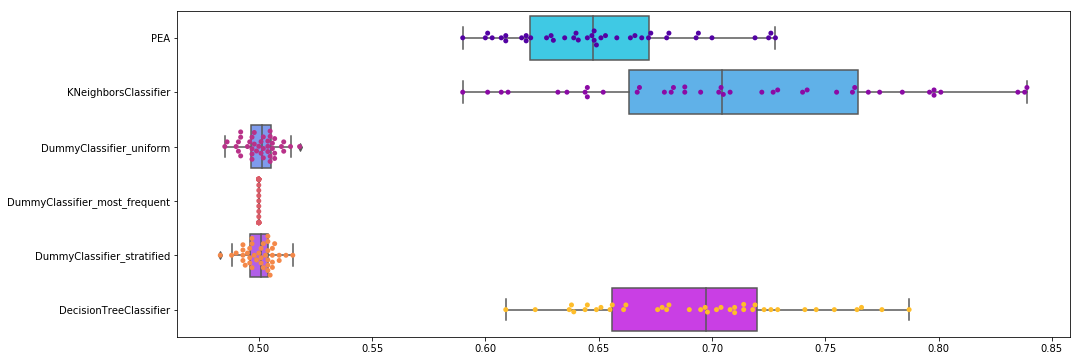

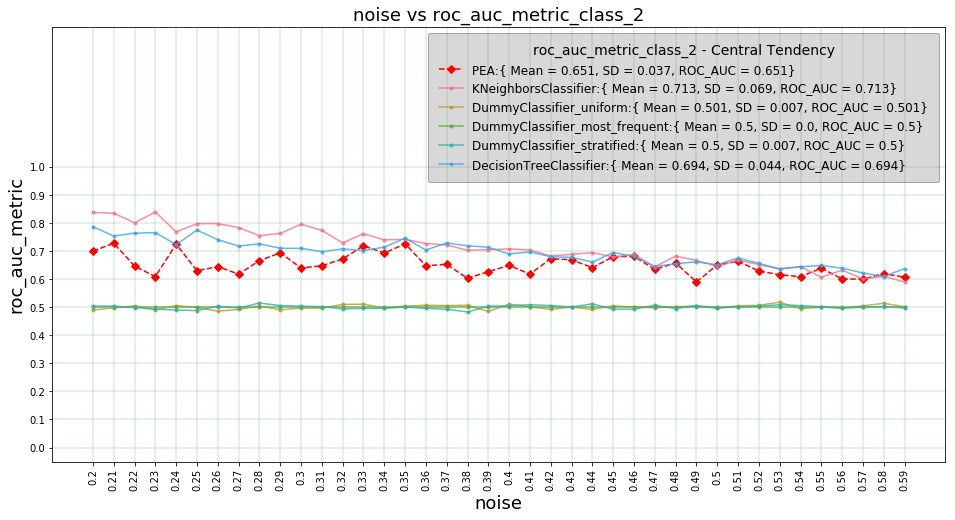

In [216]:
clf_list = [
     PerformanceEnrichmentAnalysisClassifier(
        number_of_clusters=20, permutations=100),
     KNeighborsClassifier(3),
     DummyClassifier(strategy='uniform'),
     DummyClassifier(strategy='most_frequent'),
     DummyClassifier(strategy='stratified'),
     # SVC(kernel="linear", C=0.025),
     # SVC(gamma=2, C=1),
     DecisionTreeClassifier(max_depth=5),
     # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
     # MLPClassifier(alpha=0.01),
     # AdaBoostClassifier(),
     # GaussianNB(),
     # QuadraticDiscriminantAnalysis()
]

# roc_auc_metric, precision_recall, fnr, fpr, sensitivity, specificity
noise_list = list(np.round(np.arange(0.2, 0.6, 0.01),2))
df_1, roc_dict = create_dict_clf_noise_classwise_updated(classifier_list=clf_list, 
                                                         metric= 'roc_auc_metric', 
                                                         class_label='2', 
                                                         folds=5, 
                                                         list_values = noise_list)

In [212]:
#     fig, ax = plt.subplots(figsize=(16,10))
#     df_2 = df_1.copy()
#     df_2.reset_index(inplace=True)
#     display(df_2.columns[1:])
#     marker_style_PEA = dict(color='red', linestyle='--', marker='D',
#                     markersize=5)
#     marker_style_other = dict(marker='o',
#                     markersize=3)
#     for column in df_1.columns[1:]:
#         if column=='PEA':
#             ax.plot(df_2['noise'], df_2[column], **marker_style_PEA)
#         else:
#             ax.plot(df_2['noise'], df_2[column], alpha=0.8, **marker_style_other)
#     ax.set_xticklabels(df_2['noise'], rotation=90)
#     ax.set_xticks(df_2['noise']);
 
#     #ax.set_xlabel(metric,fontsize=18)
#     #ax.set_ylabel(param,fontsize=18)
    
#     ax.set_ylim(-0.05,1.5)
#     ax.set_yticks(np.arange(0,1.01,0.1))
#     ax.grid(which='major', linestyle='-', linewidth='0.3', color='green', alpha=0.7)
    
# #     for column in df_1.columns[1:]:
# #         for x, y in zip(df_1['noise'], df_1[column]): 
# #             label = "{:.2f}".format(y)
# #             ax.annotate('(%s)' % label, xy=(x, y), textcoords='data', fontsize=7) # <--
    
#     ax_legend_list = []
#     clf_list = df_1.columns[1:]

#     metric= 'roc_auc_metric'
#     class_label = '0'
#     param='a'
#     ax.set_title(str(metric)+'vs'+str(param)+'_class_'+class_label,fontsize=18)
#     for i in range(len(df_1.columns[1:])):
#         display(clf_list[i])
#         ax_legend_list.append(str(clf_list[i])+':{ Mean = '+ str(round(df_1.mean(),3)[i+1]) +', SD = '+str(round(df_1.std(),3)[i+1])+', ROC_AUC = '+str(roc_dict[clf_list[i]])+'}')
    
#     display(ax_legend_list)
    
#     ax.legend(ax_legend_list, fontsize=12, framealpha=0.4, facecolor='grey', fancybox=True, edgecolor='black', title= str(metric)+'_class_'+class_label+' - Central Tendency', title_fontsize=14, borderpad=.9)
    



'KNeighborsClassifier'

'DummyClassifier_uniform'

'DummyClassifier_most_frequent'

'DummyClassifier_stratified'

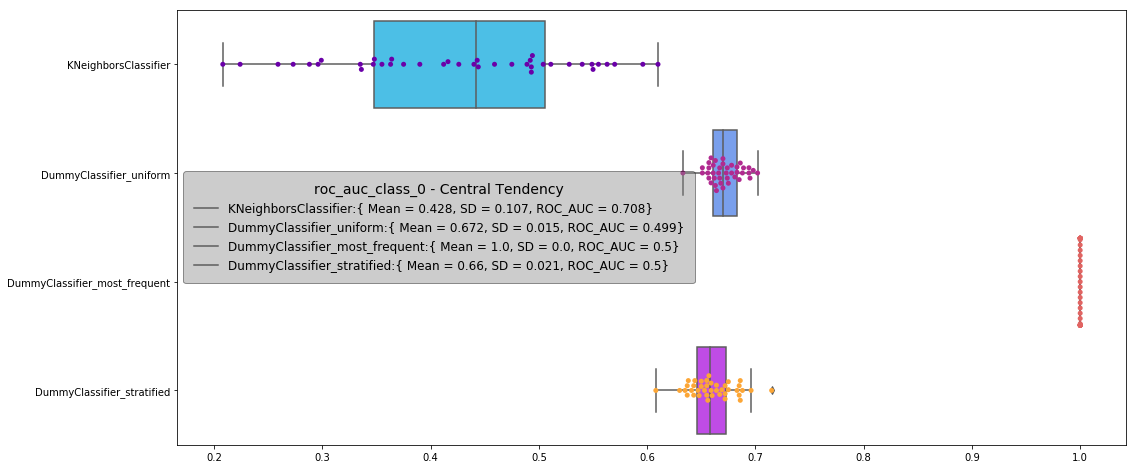

In [215]:
plt.figure(figsize=(17,8))
sns.boxplot(data=df_1.iloc[:,1:], orient='h', palette='cool')
sns.swarmplot(data=df_1.iloc[:,1:],orient='h', palette='plasma')

ax_legend_list = []
clf_list = df_1.columns[1:]
metric= 'roc_auc'
class_label = '0'
param='a'
    
for i in range(len(df_1.columns[1:])):
        display(clf_list[i])
        ax_legend_list.append(str(clf_list[i])+':{ Mean = '+ str(round(df_1.mean(),3)[i+1]) +', SD = '+str(round(df_1.std(),3)[i+1])+', ROC_AUC = '+str(roc_dict[clf_list[i]])+'}')
        
plt.legend(ax_legend_list, fontsize=12, framealpha=0.4, facecolor='grey', fancybox=True, edgecolor='black', title= str(metric)+'_class_'+class_label+' - Central Tendency', title_fontsize=14, borderpad=.9)

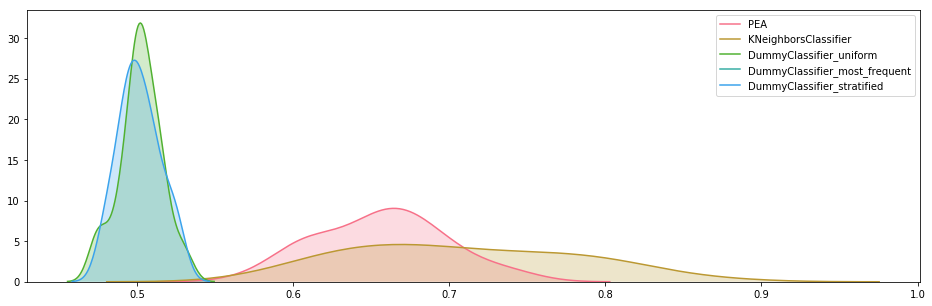

In [130]:
plt.figure(figsize=(16,5))

for col in df_1.columns[1:]:
    sns.kdeplot(df_2[col], shade=True)
    #plt.axvline(df_2[col].mean(), linewidth=1)
    
sns.set_palette("husl")